# Preparation

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import Row
# from pyspark.sql.types import StringType, StructType, StructField
from pyspark.sql.types import *
# import pyspark.sql.functions as F
from pyspark.sql.functions import *

import warnings
warnings.filterwarnings('ignore')

In [22]:
plt.rcParams["axes.unicode_minus"] = False 

# Q1

## Q1_1

In [23]:
spark = SparkSession.builder.config('spark.ui.port', 64050).appName("proj1_q1").getOrCreate()

In [24]:
spark.read.text("data/maccdc-2012/00/http.log.gz").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                                   

notice that the data is stored in a json format, so we can use `spark.read.json` to read the data.

In [25]:
df_http = spark.read.json("data/maccdc-2012/00/http.log.gz")

df_http.show(5, truncate=False)

+---------------+--------------+---------+---------------+---------+------+--------------+----------+---------------+------+-------+--------+----------------+----------+---------------+-----------------+-----------+----------+----+-----------+---------------+------------------+--------------+------------------------------------------------------------------------------+--------+-------+
|host           |id.orig_h     |id.orig_p|id.resp_h      |id.resp_p|method|orig_filenames|orig_fuids|orig_mime_types|origin|proxied|referrer|request_body_len|resp_fuids|resp_mime_types|response_body_len|status_code|status_msg|tags|trans_depth|ts             |uid               |uri           |user_agent                                                                    |username|version|
+---------------+--------------+---------+---------------+---------+------+--------------+----------+---------------+------+-------+--------+----------------+----------+---------------+-----------------+-----------+-----

Given a path list, the function should read the data from the path list and return a dataframe.

In [26]:
folders = ["00", "01", "02", "03", "04", "05"]
df_http = spark.read.json([f"data/maccdc-2012/{folder}/http.log.gz" for folder in folders])
df_dns = spark.read.json([f"data/maccdc-2012/{folder}/dns.log.gz" for folder in folders])

In [27]:
df_http.select(col("ts")).show(2)
df_dns.select(col("ts")).show(2)

+---------------+
|             ts|
+---------------+
|1.33191073224E9|
|1.33191073239E9|
+---------------+
only showing top 2 rows

+---------------+
|             ts|
+---------------+
|1.33191073286E9|
|1.33191073286E9|
+---------------+
only showing top 2 rows



In [28]:
df_http = df_http.withColumn("ts", to_timestamp(col("ts")))
df_dns = df_dns.withColumn("ts", to_timestamp(col("ts")))
df_http.select(col("ts")).show(2,truncate=False)
df_dns.select(col("ts")).show(2,truncate=False)

+----------------------+
|ts                    |
+----------------------+
|2012-03-16 15:12:12.24|
|2012-03-16 15:12:12.39|
+----------------------+
only showing top 2 rows

+----------------------+
|ts                    |
+----------------------+
|2012-03-16 15:12:12.86|
|2012-03-16 15:12:12.86|
+----------------------+
only showing top 2 rows



In [29]:
df_http.createOrReplaceTempView("http_log")
df_dns.createOrReplaceTempView("dns_log")

## Q1_2

In [30]:
spark.sql("SELECT status_code,method,uri FROM http_log LIMIT 5").show()

+-----------+------+--------------------+
|status_code|method|                 uri|
+-----------+------+--------------------+
|      302.0|  POST|           /doku.php|
|      301.0|   GET|/sdk/vimService?wsdl|
|      200.0|   GET|         /index.html|
|      200.0|   GET| /doku.php?id=start&|
|      304.0|   GET|/lib/tpl/default/...|
+-----------+------+--------------------+



### Spark SQL API

In [31]:
spark.sql("SELECT uri, COUNT(uri) AS uri_count FROM http_log WHERE status_code = 200 AND method = 'GET' GROUP BY uri order by uri_count desc").show(5)

+--------------------+---------+
|                 uri|uri_count|
+--------------------+---------+
|                   /|     9475|
|/admin/config.php...|      556|
|  /main.php?logout=1|      194|
|/top.php?stuff=15...|      191|
|            /top.php|      179|
+--------------------+---------+
only showing top 5 rows



### Spark dataframe API

In [32]:
df_http.select(col("uri")).filter((col("status_code")==200) & (col("method")=='GET')).groupBy(col("uri")).agg(count(col("uri")).alias("uri_count")).orderBy(col("uri_count").desc()).show(5)

+--------------------+---------+
|                 uri|uri_count|
+--------------------+---------+
|                   /|     9475|
|/admin/config.php...|      556|
|  /main.php?logout=1|      194|
|/top.php?stuff=15...|      191|
|            /top.php|      179|
+--------------------+---------+
only showing top 5 rows



## Q1_3

In [33]:
spark.sql('''
    SELECT h.uri, COUNT(uri) AS uri_count,
    SUM(CASE when proto='tcp' THEN 1 ELSE 0 END) as tcp_count,
    tcp_count/uri_count as tcp_ratio
    From http_log h 
    Join dns_log d on h.uid = d.uid
    Where h.status_code = 200 AND h.method = 'GET'
    Group By uri
    Order By tcp_ratio desc    
''').show(5)

+--------------------+---------+---------+-------------------+
|                 uri|uri_count|tcp_count|          tcp_ratio|
+--------------------+---------+---------+-------------------+
|/lib/exe/indexer....|        1|        1|                1.0|
|  /get_latest_id.php|       18|        3|0.16666666666666666|
|                   /|      133|       22|0.16541353383458646|
| /_vti_bin/shtml.dll|        9|        1| 0.1111111111111111|
|/_vti_bin/_vti_au...|        9|        1| 0.1111111111111111|
+--------------------+---------+---------+-------------------+
only showing top 5 rows



## Q1_4

### calculate the freq

In [34]:
num = df_http.count()
df_http.groupBy(col("method")).agg(count(col("method")).alias("count"), (col("count")/num).alias("freq")).orderBy(col("count").desc()).show(5,truncate=False)

+-------+------+---------------------+
|method |count |freq                 |
+-------+------+---------------------+
|GET    |136678|0.7354368670834992   |
|POST   |40184 |0.21622203329638517  |
|HEAD   |4805  |0.025854739945976778 |
|OPTIONS|2388  |0.012849348385222174 |
|CONNECT|84    |4.5198712912841813E-4|
+-------+------+---------------------+
only showing top 5 rows



### Plot pie charts

In [35]:
df_pie = df_http.groupBy(col("method"),col("status_code")).agg(count("*").alias("count")).orderBy(col("method"),col("status_code"))
df_pie = df_pie.toPandas()
df_pie

,method,status_code,count
0,None,NaN,18
1,None,400.0,1299
2,None,414.0,59
3,BXNTPG,200.0,1
4,CONNECT,400.0,21
...,...,...,...
117,some,NaN,3
118,some,400.0,10
119,some,500.0,3
120,some,505.0,1


In [36]:
method_count = df_pie["method"].value_counts()
method_count

method
GET            14
OPTIONS        11
POST           10
HEAD            9
PROPFIND        7
TRACE           7
PUT             6
Secure          6
SEARCH          6
NESSUS          5
TRACK           5
some            4
CONNECT         3
GNUTELLA        2
DELETE          2
RPC_CONNECT     2
DESCRIBE        2
BXNTPG          1
FHGDMH          1
OEDNGQ          1
NVKHMY          1
KTGFFX          1
MCPWYV          1
JZUIPY          1
EQAONR          1
GATMQW          1
FPANCV          1
EAILCX          1
PCKOIZ          1
RDWWEM          1
UIZUPR          1
WOIGAG          1
XORXZY          1
YVFUKU          1
user            1
Name: count, dtype: int64

In [37]:
method_list = method_count[method_count>1].index
method_list

Index(['GET', 'OPTIONS', 'POST', 'HEAD', 'PROPFIND', 'TRACE', 'PUT', 'Secure',
       'SEARCH', 'NESSUS', 'TRACK', 'some', 'CONNECT', 'GNUTELLA', 'DELETE',
       'RPC_CONNECT', 'DESCRIBE'],
      dtype='object', name='method')

As some methods are only found once, they will be omitted when plotting pie charts

In [38]:
plt.style.use("fivethirtyeight")

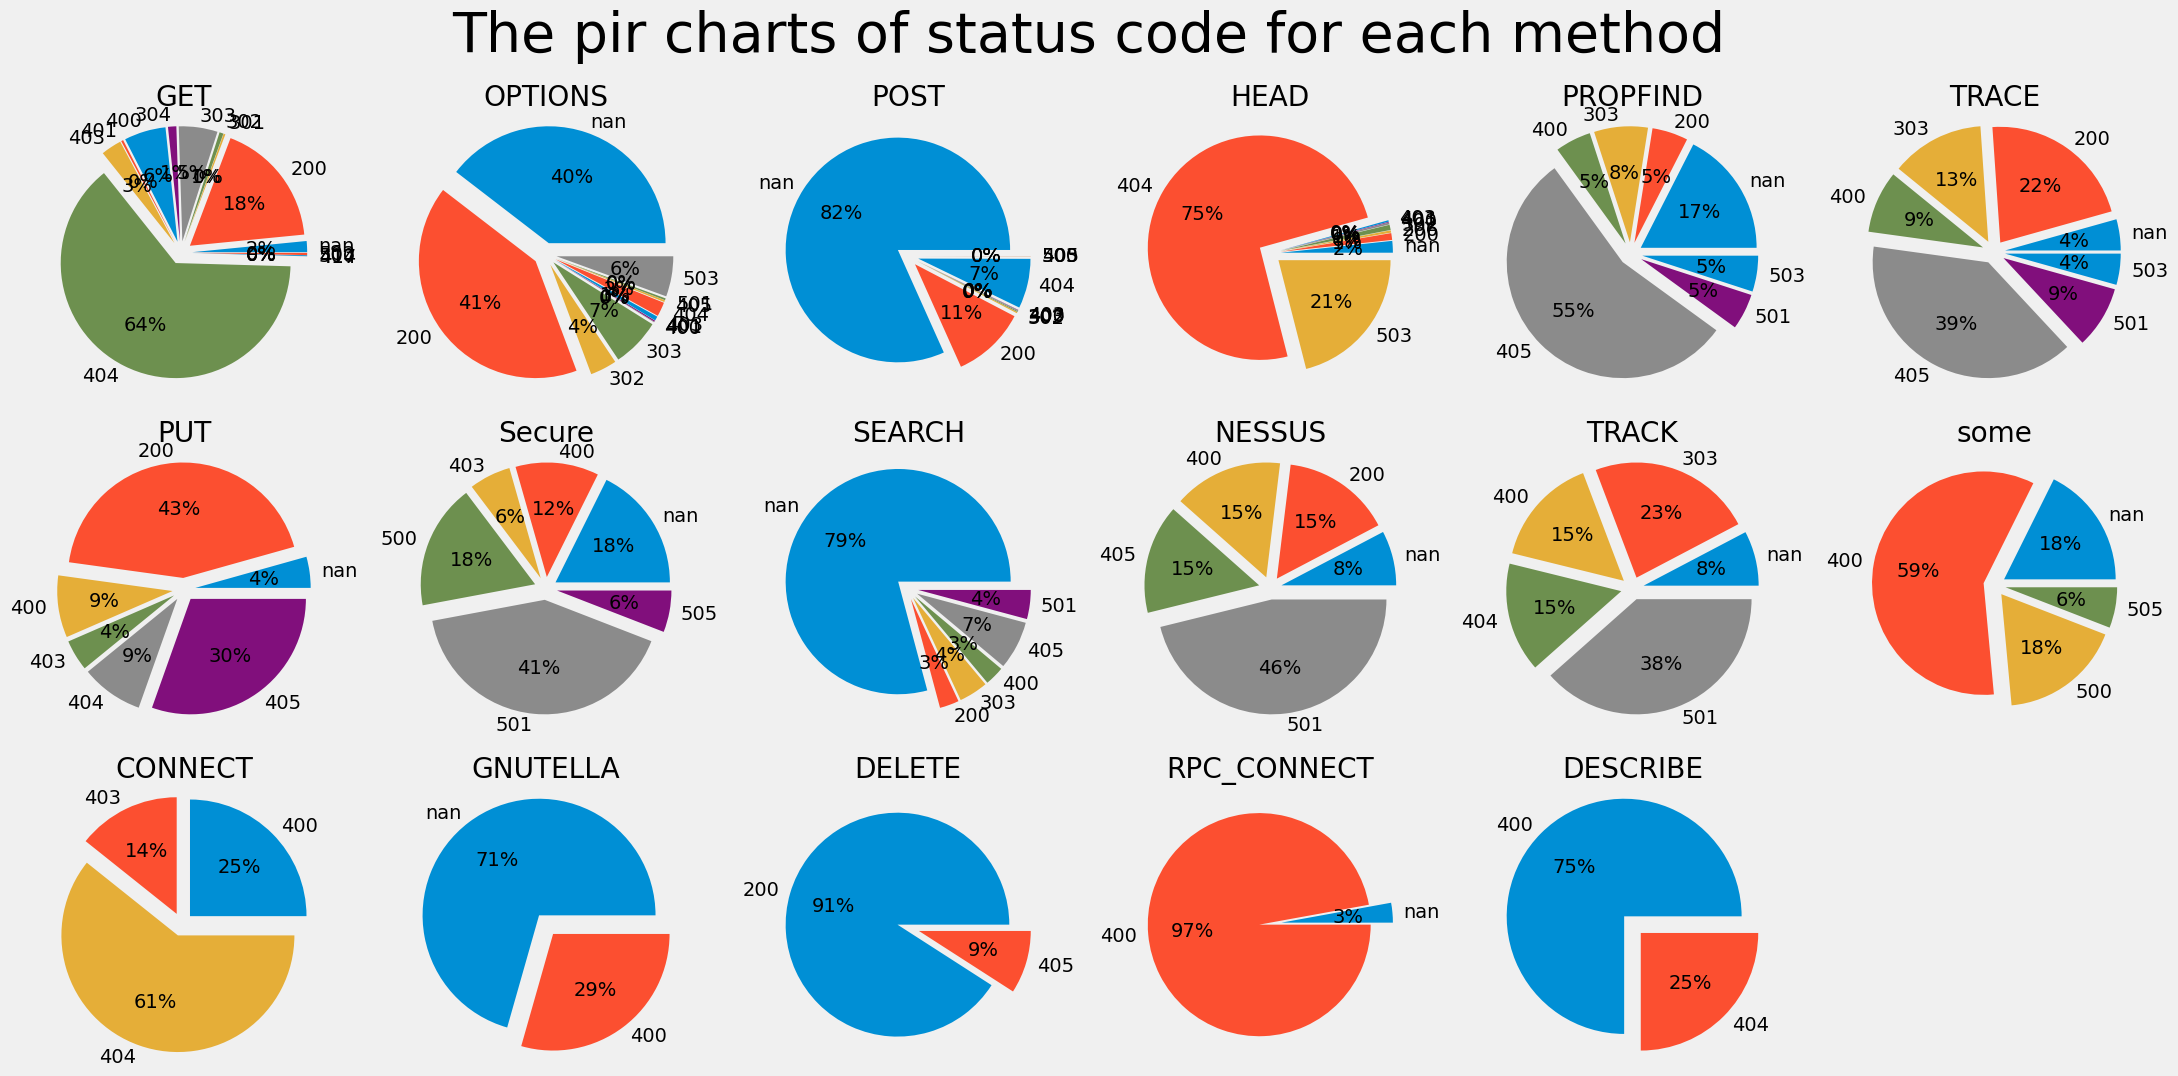

In [44]:
fig,ax = plt.subplots(3,6,figsize=(22,11))
plt.suptitle("The pir charts of status code for each method",fontsize  = 40)
plt.subplots_adjust(top = 0.87,wspace=0.3,hspace=0.18)

for i,method in enumerate(method_list):
    df_method = df_pie[df_pie["method"]==method]
    ax[i//6,i%6].pie(df_method["count"],labels=df_method["status_code"].apply(lambda x : str(int(x)) if pd.notnull(x) else x ),autopct='%1.f%%',explode = [0.1]*len(df_method))
    ax[i//6,i%6].set_title(method)
    ax[i//6,i%6].axis("equal")
    # ax[i//6,i%6].legend(loc="upper left",fontsize = 6)

fig.delaxes(ax[2,5])
plt.tight_layout()
fig.savefig("output/proj1_q1_pie.svg")

In [40]:
spark.stop()